Copyright (C) 2025 Advanced Micro Devices, Inc. All rights reserved.
Portions of this notebook consist of AI-generated content.

Permission is hereby granted, free of charge, to any person obtaining a copy

of this software and associated documentation files (the "Software"), to deal

in the Software without restriction, including without limitation the rights

to use, copy, modify, merge, publish, distribute, sublicense, and/or sell

copies of the Software, and to permit persons to whom the Software is

furnished to do so, subject to the following conditions:



The above copyright notice and this permission notice shall be included in all

copies or substantial portions of the Software.



THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR

IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,

FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE

AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER

LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,

OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE

SOFTWARE.

# CV07 Variational Autoencoder (VAE) and Conditional Variational Autoencode (cVAE)

### Lab Description

This laboratory exercise introduces **Variational Autoencoders (VAEs)**, a generative deep learning model that combines ideas from autoencoders and probabilistic graphical models. Unlike traditional autoencoders, VAEs learn a **probabilistic latent space** that enables controlled sampling and meaningful interpolation between data points.

In this hands-on lab, you will train a VAE on the `MNIST` dataset, monitor the training process through loss curves, and visualize both reconstructed digits and newly generated samples from the learned latent space.

### What you can expect to learn

- **Theoretical Understanding**: Understand the concept of latent variable models, the reparameterization trick, and the Evidence Lower Bound (ELBO).  
- **Implementation of VAE**: Learn how to build encoder–decoder architectures for variational inference in PyTorch.  
- **Training & Monitoring**: Track per-epoch time, batch size, and VRAM usage, while observing convergence through reconstruction and KL divergence losses.  
- **Visualization & Evaluation**:  
  - Plot training curves to verify the correctness of learning direction.  
  - Generate digit reconstructions to assess model quality.  
  - Sample from the latent space to visualize how the VAE creates new data points.  


In [1]:
import sys, platform, torch, torchvision
print("Python:", sys.version.split()[0])
print("PyTorch:", torch.__version__)
print("Torchvision:", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))

Python: 3.10.19
PyTorch: 2.10.0.dev20251101+rocm7.0
Torchvision: 0.25.0.dev20251102+rocm7.0
CUDA available: True
CUDA device: AMD Radeon AI PRO R9700


## 1. Import necessary libraries

In [2]:
import os, time
from dataclasses import dataclass
import math
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils as vutils
import matplotlib.pyplot as plt

# NOTE (Lab rule for plotting): use matplotlib only, no seaborn, no explicit colors.

@dataclass
class CFG:
    model: str = "vae" # or "cvae"
    seed: int = 42
    batch_size: int = 128     # <- Feel free to change; it will be reported at the end
    epochs: int = 10
    lr: float = 1e-3
    latent_dim: int = 16
    img_size: int = 28
    num_classes: int = 10
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

cfg = CFG()

def set_seed(seed=42):
    import random, numpy as np
    random.seed(seed); torch.manual_seed(seed); np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(cfg.seed)
cfg

CFG(model='vae', seed=42, batch_size=128, epochs=10, lr=0.001, latent_dim=16, img_size=28, num_classes=10, device='cuda')

In [3]:
# Base data directories
DATA_DIR = os.path.expanduser("~/data")
os.makedirs(DATA_DIR, exist_ok=True)
print("DATA_DIR:", DATA_DIR)

# VAE output directories
VAE_OUTPUT_DIR = os.path.expanduser("~/data/vae_outputs")
os.makedirs(VAE_OUTPUT_DIR, exist_ok=True)
print("VAE_OUTPUT_DIR:", VAE_OUTPUT_DIR)

# cVAE output directories
cVAE_OUTPUT_DIR = os.path.expanduser("~/data/cvae_outputs")
os.makedirs(cVAE_OUTPUT_DIR, exist_ok=True)
print("cVAE_OUTPUT_DIR:", cVAE_OUTPUT_DIR)

DATA_DIR: /home/aup/data
VAE_OUTPUT_DIR: /home/aup/data/vae_outputs
cVAE_OUTPUT_DIR: /home/aup/data/cvae_outputs


## 2. Required Dataset
We use the `MNIST` dataset for this lab.  
`MNIST` is a large database of handwritten digits (0–9), widely used for training and testing image processing systems.   

More information can be found on the official MNIST website:  
http://yann.lecun.com/exdb/mnist/

In [4]:
transform = transforms.ToTensor()

train_ds = datasets.MNIST(root=DATA_DIR, train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root=DATA_DIR, train=False, download=True, transform=transform)

train_loader = DataLoader(
    train_ds, batch_size=cfg.batch_size, shuffle=True,
    num_workers=2, pin_memory=True if torch.cuda.is_available() else False
)
test_loader  = DataLoader(
    test_ds, batch_size=cfg.batch_size, shuffle=False,
    num_workers=2, pin_memory=True if torch.cuda.is_available() else False
)

len(train_ds), len(test_ds)


(60000, 10000)

## 3. Model: Variational Autoencoder
We define the encoder, decoder, and VAE wrapper class.  
The encoder outputs mean `mu` and log-variance `logvar`, then we apply the **reparameterization trick** to sample latent vectors `z`.  
The decoder reconstructs images from `z`.

In [5]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=16, num_classes=10, conditional: bool = False):
        super().__init__()
        self.conditional = conditional
        self.num_classes = num_classes

        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 2, 1), nn.ReLU(True),  # 28 -> 14
            nn.Conv2d(32, 64, 3, 2, 1), nn.ReLU(True), # 14 -> 7
        )
        self.flatten = nn.Flatten()
        feat_dim = 64 * 7 * 7
        in_dim = feat_dim + (num_classes if conditional else 0)

        self.fc_mu   = nn.Linear(in_dim, latent_dim)
        self.fc_logv = nn.Linear(in_dim, latent_dim)

    def forward(self, x, y_onehot: torch.Tensor | None = None):
        """
        x: (B,1,28,28)
        y_onehot: (B,num_classes) or None
        """
        h = self.conv(x)
        h = self.flatten(h)  # (B, 64*7*7)

        if self.conditional:
            if y_onehot is None:
                raise ValueError("Encoder in conditional mode requires y_onehot.")
            h = torch.cat([h, y_onehot], dim=1)

        mu, logvar = self.fc_mu(h), self.fc_logv(h)
        return mu, logvar


class Decoder(nn.Module):
    def __init__(self, latent_dim=16, num_classes=10, conditional: bool = False):
        super().__init__()
        self.conditional = conditional
        self.num_classes = num_classes

        in_dim = latent_dim + (num_classes if conditional else 0)
        self.fc = nn.Linear(in_dim, 64 * 7 * 7)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(True),  # 7 -> 14
            nn.ConvTranspose2d(32, 1, 4, 2, 1)                   # 14 -> 28
        )

    def forward(self, z, y_onehot: torch.Tensor | None = None):
        if self.conditional:
            if y_onehot is None:
                raise ValueError("Decoder in conditional mode requires y_onehot.")
            z = torch.cat([z, y_onehot], dim=1)
        h = self.fc(z)
        h = h.view(-1, 64, 7, 7)
        x_hat_logits = self.deconv(h)  # (B,1,28,28) logits
        return x_hat_logits


# =========================
# UnifiedVAE（use same forward for both VAE and cVAE）
# =========================
class UnifiedVAE(nn.Module):
    def __init__(self, latent_dim=16, num_classes=10, mode: str = "vae"):
        super().__init__()
        mode = mode.lower()
        assert mode in {"vae", "cvae"}, "mode must be 'vae' or 'cvae'"
        self.conditional = (mode == "cvae")
        self.num_classes = num_classes

        self.encoder = Encoder(latent_dim, num_classes, conditional=self.conditional)
        self.decoder = Decoder(latent_dim, num_classes, conditional=self.conditional)

    @staticmethod
    def reparameterize(mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, y: torch.Tensor | None = None):
        """
        x: (B,1,28,28)
        y: (B,) class indices OR None
        return: x_hat_logits, mu, logvar
        """
        y_onehot = None
        if self.conditional:
            if y is None:
                raise ValueError("UnifiedVAE in cVAE mode requires y labels.")
            y_onehot = F.one_hot(y, num_classes=self.num_classes).float()

        mu, logvar = self.encoder(x, y_onehot)
        z = self.reparameterize(mu, logvar)
        x_hat_logits = self.decoder(z, y_onehot)
        return x_hat_logits, mu, logvar

## 4. Loss: ELBO (Reconstruction + KL)
We use pixel-wise **BCE** reconstruction loss (common for MNIST in `[0,1]`) and the analytical **KL divergence** term.  
Together they form the **Evidence Lower Bound (ELBO)** objective.

In [6]:
# Using BCE reconstruction loss (common for MNIST) and analytical KL term.
bce = nn.BCELoss(reduction='sum')

def elbo_loss(x_hat, x, mu, logvar):
    recon = bce(x_hat, x)
    kl = 0.5 * torch.sum(torch.exp(logvar) + mu**2 - 1.0 - logvar)
    total = recon + kl
    return total, recon, kl


## 5. Training Loop
We train the VAE/cVAE, recording:  
- Per-epoch training time  
- Reconstruction loss, KL loss, total loss  
- Peak GPU memory usage  

In [7]:
from torch.amp import GradScaler

# -------- utils --------
def _cuda_index(dev):
    d = torch.device(dev) if not isinstance(dev, torch.device) else dev
    if d.type != "cuda":
        return None
    return d.index if d.index is not None else torch.cuda.current_device()

def gpu_reset_peaks():
    if torch.cuda.is_available():
        idx = _cuda_index(device)
        if idx is not None:
            torch.cuda.reset_peak_memory_stats(idx)
            torch.cuda.empty_cache()

def get_peak_vram_mb():
    if torch.cuda.is_available():
        idx = _cuda_index(device)
        if idx is not None:
            return torch.cuda.max_memory_allocated(idx) / (1024 ** 2)
    return 0.0
    
def pick_amp_dtype():
    try:
        if torch.cuda.is_available() and hasattr(torch.cuda, "is_bf16_supported") and torch.cuda.is_bf16_supported():
            return torch.bfloat16
        return torch.float16
    except Exception:
        return torch.float16
import subprocess, json, re

def get_vram_util():
    if not torch.cuda.is_available():
        return 0.0, 0.0, 0.0
    idx = _cuda_index(device)
    if idx is None:
        return 0.0, 0.0, 0.0
    tot = torch.cuda.get_device_properties(idx).total_memory / (1024**2)
    cur = torch.cuda.memory_allocated(idx) / (1024**2)
    pct = (cur / tot * 100.0) if tot > 0 else 0.0
    return pct, cur, tot

# -------- metrics --------
def accuracy(logits, targets, topk=(1,)):
    with torch.no_grad():
        if logits.dim() == 2:
            maxk = max(topk)
            _, pred = logits.topk(maxk, dim=1, largest=True, sorted=True)
            pred = pred.t()
            correct = pred.eq(targets.view(1, -1).expand_as(pred))
            res = []
            for k in topk:
                correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
                res.append((correct_k.mul_(100.0 / targets.size(0))).item())
            return res

        elif logits.dim() == 4:
            N, C, H, W = logits.shape
            maxk = max(topk)
            k_used = min(maxk, C)
            topk_idx = logits.topk(k_used, dim=1, largest=True, sorted=True).indices  # [N,k,H,W]
            tgt = targets.view(N, 1, H, W)

            res = []
            for k in topk:
                kk = min(k, C)
                correct_pix = (topk_idx[:, :kk, :, :] == tgt).any(dim=1).float()  # [N,H,W]
                acc_per_img = correct_pix.view(N, -1).mean(dim=1) * 100.0
                res.append(acc_per_img.mean().item())
            return res

        else:
            raise ValueError("logits dim should be [N,C] or [N,C,H,W]")

# -------- train/val --------
def train_one_epoch(model, loader, optimizer, criterion, device, scaler=None, amp_dtype=None):
    model.train()
    running_loss = running_top1 = running_top5 = 0.0
    n_samples = 0

    for images, targets in loader:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        use_amp = scaler is not None and amp_dtype is not None
        if use_amp:
            with torch.autocast(device_type="cuda", dtype=amp_dtype):
                logits = model(images)
                loss = criterion(logits, targets)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(images)
            loss = criterion(logits, targets)
            loss.backward()
            optimizer.step()

        bs = images.size(0)
        top1, top5 = accuracy(logits, targets, topk=(1, 5))
        running_loss += loss.item() * bs
        running_top1 += top1 * bs / 100.0
        running_top5 += top5 * bs / 100.0
        n_samples += bs

    return (running_loss / n_samples,
            100.0 * running_top1 / n_samples,
            100.0 * running_top5 / n_samples)

@torch.no_grad()
def validate(model, loader, criterion, device, amp_dtype=None):
    model.eval()
    running_loss = running_top1 = running_top5 = 0.0
    n_samples = 0

    for images, targets in loader:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        if amp_dtype is not None:
            with torch.autocast(device_type="cuda", dtype=amp_dtype):
                logits = model(images)
                loss = criterion(logits, targets)
        else:
            logits = model(images)
            loss = criterion(logits, targets)

        bs = images.size(0)
        top1, top5 = accuracy(logits, targets, topk=(1, 5))
        running_loss += loss.item() * bs
        running_top1 += top1 * bs / 100.0
        running_top5 += top5 * bs / 100.0
        n_samples += bs

    return (running_loss / n_samples,
            100.0 * running_top1 / n_samples,
            100.0 * running_top5 / n_samples)


In [8]:
import os, time, torch
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

def training(cfg, train_loader, 
             VAE_OUTPUT_DIR="outputs_vae",
             cVAE_OUTPUT_DIR="outputs_cvae"):
    device = torch.device(cfg.device)
    model = UnifiedVAE(cfg.latent_dim, cfg.num_classes, mode=cfg.model).to(device)
    opt = optim.Adam(model.parameters(), lr=cfg.lr)

    epoch_times = []
    train_losses, recon_losses, kl_losses = [], [], []
    peak_vram_per_epoch = []

    OUTPUT_DIR = VAE_OUTPUT_DIR if cfg.model.lower() == "vae" else cVAE_OUTPUT_DIR
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    log_path = os.path.join(OUTPUT_DIR, "log.txt")
    with open(log_path, "w") as f:
        f.write("epoch,time(s),loss,recon,kl,peak_vram(MB)\n")

    t0_total = time.perf_counter()
    is_cvae = (cfg.model.lower() == "cvae")

    for epoch in range(1, cfg.epochs + 1):
        model.train()
        gpu_reset_peaks()
        t0 = time.perf_counter()

        total_loss = 0.0
        total_recon = 0.0
        total_kl = 0.0
        total_samples = 0

        for x, y in train_loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            opt.zero_grad(set_to_none=True)

            # forward：cVAE needs y；VAE needs None
            if is_cvae:
                x_hat_logits, mu, logvar = model(x, y)
            else:
                x_hat_logits, mu, logvar = model(x, None)

            x_hat = torch.sigmoid(x_hat_logits)

            loss, recon, kl = elbo_loss(x_hat, x, mu, logvar)
            loss.backward()
            opt.step()

            bs = x.size(0)
            total_loss  += loss.item()
            total_recon += recon.item()
            total_kl    += kl.item()
            total_samples += bs

        if torch.cuda.is_available():
            idx = _cuda_index(device)
            if idx is not None:
                torch.cuda.synchronize(idx)

        epoch_time = time.perf_counter() - t0
        epoch_times.append(epoch_time)

        peak = get_peak_vram_mb()
        peak_vram_per_epoch.append(peak)

        avg_loss  = total_loss / max(1, total_samples)
        avg_recon = total_recon / max(1, total_samples)
        avg_kl    = total_kl / max(1, total_samples)
        train_losses.append(avg_loss)
        recon_losses.append(avg_recon)
        kl_losses.append(avg_kl)

        vram_pct, vram_cur, vram_tot = get_vram_util()
        total_time = time.perf_counter() - t0_total

        msg = (f"[{cfg.model.upper()}] Epoch {epoch:02d}/{cfg.epochs} | "
               f"time {epoch_time:.2f}s | total {total_time:.1f}s | "
               f"VRAM {vram_pct:.1f}% ({vram_cur:.0f}/{vram_tot:.0f} MB) | "
               f"loss {avg_loss:.4f} recon {avg_recon:.4f} kl {avg_kl:.4f} | "
               f"peak VRAM {peak:.1f} MB")
        print(msg)

        with open(log_path, "a") as f:
            f.write(f"{epoch},{epoch_time:.2f},{avg_loss:.4f},{avg_recon:.4f},{avg_kl:.4f},{peak:.1f}\n")

        if (epoch % 10) == 0:
            ckpt_path = os.path.join(
                OUTPUT_DIR,
                f"{cfg.model}_checkpoint_epoch_{epoch}.pth"
            )
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": opt.state_dict(),
                "loss": avg_loss,
                "cfg": dict(cfg.__dict__),
            }, ckpt_path)

    return {
        "epoch_times": epoch_times,
        "train_losses": train_losses,
        "recon_losses": recon_losses,
        "kl_losses": kl_losses,
        "peak_vram_per_epoch": peak_vram_per_epoch,
    }, model

stats, model = training(cfg, train_loader, VAE_OUTPUT_DIR=VAE_OUTPUT_DIR, cVAE_OUTPUT_DIR=cVAE_OUTPUT_DIR)


device: cuda
[VAE] Epoch 01/10 | time 9.23s | total 9.2s | VRAM 0.5% (156/32624 MB) | loss 159.9985 recon 139.3426 kl 20.6559 | peak VRAM 171.3 MB
[VAE] Epoch 02/10 | time 8.84s | total 18.1s | VRAM 0.5% (156/32624 MB) | loss 117.4549 recon 93.7290 kl 23.7259 | peak VRAM 171.3 MB
[VAE] Epoch 03/10 | time 8.82s | total 26.9s | VRAM 0.5% (156/32624 MB) | loss 111.9641 recon 88.1008 kl 23.8632 | peak VRAM 171.3 MB
[VAE] Epoch 04/10 | time 8.90s | total 35.8s | VRAM 0.5% (156/32624 MB) | loss 109.4004 recon 85.4681 kl 23.9322 | peak VRAM 171.3 MB
[VAE] Epoch 05/10 | time 8.85s | total 44.7s | VRAM 0.5% (156/32624 MB) | loss 107.8336 recon 83.8465 kl 23.9871 | peak VRAM 171.3 MB
[VAE] Epoch 06/10 | time 8.80s | total 53.5s | VRAM 0.5% (156/32624 MB) | loss 106.8312 recon 82.7042 kl 24.1270 | peak VRAM 171.3 MB
[VAE] Epoch 07/10 | time 8.89s | total 62.3s | VRAM 0.5% (156/32624 MB) | loss 105.9766 recon 81.8115 kl 24.1652 | peak VRAM 171.3 MB
[VAE] Epoch 08/10 | time 8.91s | total 71.3s | VR

## 6. Training Curves
We plot losses to verify that training is proceeding correctly.

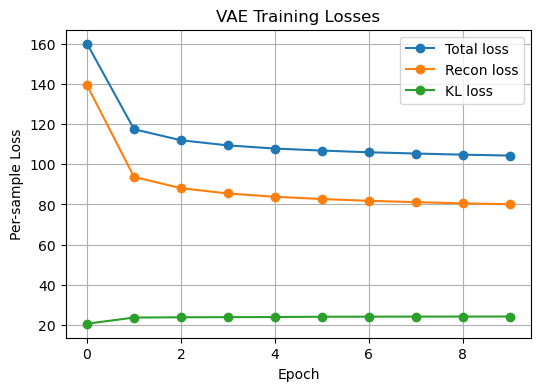

In [9]:
plt.figure(figsize=(6,4))
plt.plot(stats["train_losses"], marker='o', label='Total loss')
plt.plot(stats["recon_losses"], marker='o', label='Recon loss')
plt.plot(stats["kl_losses"], marker='o', label='KL loss')

plt.xlabel("Epoch")
plt.ylabel("Per-sample Loss")
plt.title(f"{cfg.model.upper()} Training Losses")
plt.grid(True)
plt.legend()
plt.show()


## 7. Reconstructions & Class-Conditioned Samples
We visualize:  
- **Reconstructions**: feed test images into the model and compare outputs with originals.  
- **Class-conditioned samples**: sample `z ~ N(0, I)` and decode together with chosen labels (e.g., digits 0–9).  

This demonstrates the VAE/cVAE’s ability to generate specific digits.

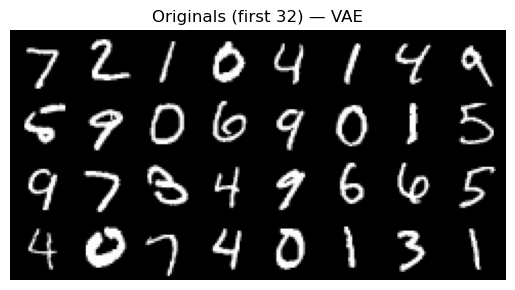

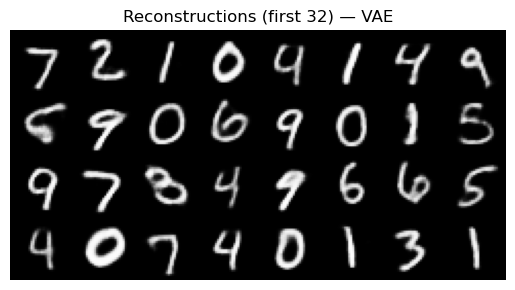

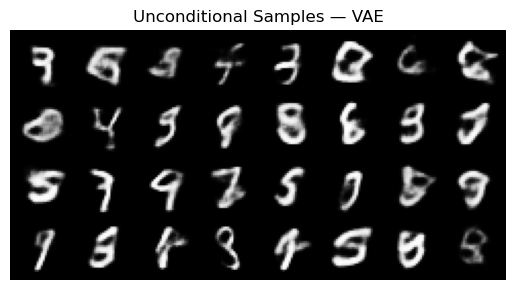

In [10]:
is_cvae = (cfg.model.lower() == "cvae")
model.eval()

with torch.no_grad():
    # -------- Reconstructions --------
    x, y = next(iter(test_loader))
    x = x.to(device, non_blocking=True)
    y = y.to(device, non_blocking=True)

    if is_cvae:
        x_hat_logits, _, _ = model(x, y)
    else:
        x_hat_logits, _, _ = model(x, None)

    x_hat = torch.sigmoid(x_hat_logits)

    x_vis = x[:32].cpu()
    xhat_vis = x_hat[:32].cpu()

    grid_in = vutils.make_grid(x_vis, nrow=8, padding=2)
    grid_out = vutils.make_grid(xhat_vis, nrow=8, padding=2)

    plt.figure()
    plt.title(f"Originals (first 32) — {cfg.model.upper()}")
    plt.axis("off")
    plt.imshow(grid_in.permute(1, 2, 0).numpy())
    plt.show()

    plt.figure()
    plt.title(f"Reconstructions (first 32) — {cfg.model.upper()}")
    plt.axis("off")
    plt.imshow(grid_out.permute(1, 2, 0).numpy())
    plt.show()

    # -------- Conditional / Unconditional Samples --------
    n = 32
    z = torch.randn(n, cfg.latent_dim, device=device)

    if is_cvae:
        target_labels = torch.tensor([i % cfg.num_classes for i in range(n)], device=device)
        y_onehot = F.one_hot(target_labels, num_classes=cfg.num_classes).float()
        logits_samples = model.decoder(z, y_onehot)
    else:
        logits_samples = model.decoder(z, None)

    samples = torch.sigmoid(logits_samples).cpu()  # 轉成 [0,1] 才能正確顯示/存檔
    grid_samples = vutils.make_grid(samples, nrow=8, padding=2)

    title = "Conditional Samples (labels 0..9 repeated)" if is_cvae else "Unconditional Samples"
    plt.figure()
    plt.title(f"{title} — {cfg.model.upper()}")
    plt.axis("off")
    plt.imshow(grid_samples.permute(1, 2, 0).numpy())
    plt.show()

    # -------- (Optional) save images --------
    OUTPUT_DIR = VAE_OUTPUT_DIR if cfg.model.lower() == "vae" else cVAE_OUTPUT_DIR
    vutils.save_image(grid_out, os.path.join(OUTPUT_DIR, "reconstructions.png"))
    vutils.save_image(grid_samples, os.path.join(OUTPUT_DIR, "samples.png"))